In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk
import joblib
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,cross_validate
import timeit
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
import sys
from sksurv.metrics import concordance_index_ipcw,concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest
from sklearn.preprocessing import StandardScaler
from pickle import load
from sksurv.nonparametric import kaplan_meier_estimator,SurvivalFunctionEstimator
from sksurv.metrics import (
    as_concordance_index_ipcw_scorer,
    as_cumulative_dynamic_auc_scorer,
    as_integrated_brier_score_scorer
)
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA,KernelPCA
from sklearn.manifold import TSNE
from pickle import dump
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest

In [2]:
n_folds = 5
random_state = 108
from datetime import date

today = date.today()
today_stf = '20241022'

In [3]:
results_fn = "results/outcome_{}.csv".format(today_stf)
try:
    results = pd.read_csv(results_fn,index_col=0)
except:
    results = pd.DataFrame(columns = ["model",
                                      "test_ci","test_ipcw","test_auc","test_brier","n_features"])
print(results)

          model   test_ci  test_ipcw  test_auc  test_brier  n_features
0           cph  0.692135   0.669471  0.698576    0.037291          75
1           cph  0.635765   0.630295  0.635606    0.036934           5
2           cph  0.662431   0.652060  0.658872    0.037187          10
3           cph  0.690876   0.675977  0.692287    0.036998          15
4           cph  0.687534   0.676775  0.686732    0.036937          20
5     ridge_cph  0.688925   0.675802  0.687202    0.036771          75
6     ridge_cph  0.685187   0.676750  0.677265    0.036880          20
7     ridge_cph  0.682904   0.677161  0.675049    0.036841          15
8     ridge_cph  0.681411   0.671781  0.671709    0.037094          10
9     ridge_cph  0.666902   0.664046  0.657276    0.037176           5
10    lasso_cph  0.692884   0.682717  0.688963    0.037021          75
11    lasso_cph  0.692404   0.687822  0.686884    0.036884          20
12    lasso_cph  0.688631   0.679441  0.683937    0.037051          15
13    

In [4]:
from sksurv.metrics import cumulative_dynamic_auc
def calc_dyn_auc(model,X,y,y_train,time_max=365,time_interval=7):
    
    times = np.arange(1e-5, time_max, time_interval)
    chf_funcs = model.predict_cumulative_hazard_function(X)
    risk_scores = np.row_stack([chf(times) for chf in chf_funcs])
    auc, mean_auc = cumulative_dynamic_auc(y_train, y, risk_scores, times)

    return auc, mean_auc,times

In [5]:
from sksurv.metrics import integrated_brier_score
def calc_ibs(model,X,y,y_train,time_max=365,time_interval=7):
    
    times = np.arange(1e-5, time_max, time_interval)
    surv_prob = np.vstack([fn(times) for fn in model.predict_survival_function(X)])
    ibs = integrated_brier_score(y_train, y, surv_prob, times)

    return ibs

In [6]:
def plot_auc(cph_auc,cph_mean_auc,times):
    plt.plot(times, cph_auc, "o-", label=f"Mean AUC = {cph_mean_auc:0.3f})")
    plt.axhline(cph_mean_auc, linestyle="--",color='r')
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.legend(loc="lower center")
    plt.grid(True)

In [7]:
def plot_cph_coef(cph,feature_names=None):
    coefs = cph.coef_.reshape((-1))
    if feature_names is None:
        feature_names = cph.feature_names_in_
    df = pd.Series(index = feature_names,data=coefs)
    non_zero_coef = df[abs(df) > 0.01].sort_values(ascending=False, key=abs).head(20)
    ax = sns.barplot(x=non_zero_coef.index, y=non_zero_coef.values)
    plt.setp(ax.get_xticklabels(), rotation=45)

In [8]:
def plot_grid_search_results(gcv, ax, name, param = "max_depth"):
    ax.errorbar(
        x=gcv.cv_results_["param_model__estimator__{}".format(param)].filled(),
        y=gcv.cv_results_["mean_test_score"],
        yerr=gcv.cv_results_["std_test_score"],
    )
    ax.plot(
        gcv.best_params_["model__estimator__{}".format(param)],
        gcv.best_score_,
        "ro",
    )
    ax.set_ylabel(name)
    ax.yaxis.grid(True)

In [9]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv)
    
    train_scores_mean = np.nanmean(train_scores, axis=1)
    train_scores_std = np.nanstd(train_scores, axis=1)
    val_scores_mean = np.nanmean(val_scores, axis=1)
    val_scores_std = np.nanstd(val_scores, axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,color='r',alpha=0.2)
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, val_scores_mean-val_scores_std, val_scores_mean+val_scores_std,color='g',alpha=0.2)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title("Learning Curves")
    plt.show()


In [10]:
def exponential_transformation_gender(row, column,gender_col, bounds, k=1):
    
    if row[gender_col] == 1:
        #male
        lower_bound, upper_bound = bounds["male"][0], bounds["male"][1]
    elif row[gender_col] == 0:
        lower_bound, upper_bound = bounds["female"][0], bounds["female"][1]
    else:
        return np.nan  # Unknown gender handling
    
    value = row[column]
    
    # Apply exponential transformation with scaling factor k
    if lower_bound <= value <= upper_bound:
        return 1  # Optimal range
    elif value < lower_bound:
        return np.exp(k * (lower_bound - value))  # Exponential penalty below range
    else:
        return np.exp(k * (value - upper_bound))  # Exponential penalty above range


In [11]:
def exponential_transformation(row, column, bounds, k=1):
    
    
    lower_bound, upper_bound = bounds[0], bounds[1]
    
    value = row[column]
    
    # Apply exponential transformation with scaling factor k
    if lower_bound <= value <= upper_bound:
        return 1  # Optimal range
    elif value < lower_bound:
        return np.exp(k * (lower_bound - value))  # Exponential penalty below range
    else:
        return np.exp(k * (value - upper_bound))  # Exponential penalty above range


In [12]:
def evaluate_score(model,X_test,y_test,y_train,model_name,time_max=365,time_interval=7):
    try:
        auc, mean_auc,times = calc_dyn_auc(model,X_test,y_test,y_train,time_max,time_interval)
    except:
         mean_auc = None
    try:
        brier = calc_ibs(model,X_test,y_test,y_train,time_max,time_interval)
    except:
        brier = None
    
    prediction = model.predict(X_test)
    c_harrell = concordance_index_censored(y_test["death_in_study"], y_test["event_max"], prediction)
    c_uno = concordance_index_ipcw(y_train, y_test, prediction,tau=time_max)
    
    results = pd.DataFrame(
        data = [[model_name,c_harrell[0],c_uno[0],mean_auc,brier,X_test.shape[1]]],
        columns = ["model", "test_ci","test_ipcw","test_auc","test_brier","n_features"]
    )
    
    return results

In [13]:
# https://www.seslhd.health.nsw.gov.au/sites/default/files/2019-04/NSWHP%20Reference%20Ranges%20Adult%202019.pdf
train = pd.read_csv("train.csv",index_col = 0)



train['haemoglobin_adj'] = train.apply(exponential_transformation_gender, axis=1, k=2e-2,
                                      column='haemoglobin',gender_col='gender_2.0',
                                     bounds={'male':(130,170),'female':(120,150)})
train['creatinine_adj'] = train.apply(exponential_transformation_gender, axis=1, k=2e-3,
                                      column='creatinine',gender_col='gender_2.0',
                                     bounds={'male':(60,110),'female':(45,90)})
train['albumin_adj'] = train.apply(exponential_transformation, axis=1, k=1e-1,
                                      column='albumin',
                                     bounds=(33,48))
train['platelet_count_adj'] = train.apply(exponential_transformation, axis=1, k=4e-6,
                                      column='platelet_count',
                                     bounds=(150e3,450e3))
#train['inr_adj'] = train.apply(exponential_transformation, axis=1, k=0.5,
#                                      column='inr',
#                                     bounds=(0.8,1.1))

# https://cardiacmri.com/analysis-guide/aortic-valve-2/aortic-stenosis-2/ using mild as upperbound
train['av_peak_vel_adj'] = train.apply(exponential_transformation, axis=1, k=0.5,
                                      column='av_peak_vel',
                                     bounds=(1,3))

# https://cardiacmri.com/analysis-guide/aortic-valve-2/aortic-stenosis-2/ 
train['av_mean_grad_tte_adj'] = train.apply(exponential_transformation, axis=1, k=2e-2,
                                      column='av_mean_grad_tte',
                                     bounds=(0,20))

train['av_area_tte_adj'] = train.apply(exponential_transformation, axis=1, k=1,
                                      column='av_area_tte',
                                     bounds=(2,np.inf))

test = pd.read_csv("test.csv",index_col = 0)
test['haemoglobin_adj'] = test.apply(exponential_transformation_gender, axis=1, k=2e-2,
                                      column='haemoglobin',gender_col='gender_2.0',
                                     bounds={'male':(130,170),'female':(120,150)})
test['creatinine_adj'] = test.apply(exponential_transformation_gender, axis=1, k=2e-3,
                                      column='creatinine',gender_col='gender_2.0',
                                     bounds={'male':(60,110),'female':(45,90)})
test['albumin_adj'] = test.apply(exponential_transformation, axis=1, k=1e-1,
                                      column='albumin',
                                     bounds=(33,48))
test['platelet_count_adj'] = test.apply(exponential_transformation, axis=1, k=4e-6,
                                      column='platelet_count',
                                     bounds=(150e3,450e3))
#test['inr_adj'] = test.apply(exponential_transformation, axis=1, k=0.5,
#                                      column='inr',
#                                     bounds=(0.8,1.1))
test['av_peak_vel_adj'] = test.apply(exponential_transformation, axis=1, k=0.5,
                                      column='av_peak_vel',
                                     bounds=(1,3))
test['av_mean_grad_tte_adj'] = test.apply(exponential_transformation, axis=1, k=2e-2,
                                      column='av_mean_grad_tte',
                                     bounds=(0,20))

test['av_area_tte_adj'] = test.apply(exponential_transformation, axis=1, k=1,
                                      column='av_area_tte',
                                     bounds=(2,np.inf))

In [14]:

#X_train = train.query('death_observed == True or death_in_study == False')
outcome_columns = ['death_in_study','upper_bound',
                       'discharge_status_new','fup_status_30d_new', 'fup_status_12mth_new','lower_bound','death_observed',
                  'event_observed', 'event_max','event_min','event_mid']
X_train = train.drop(outcome_columns,axis=1)
X_train = X_train.drop(["egfr_pre"],axis=1)

In [15]:
categorical_columns_to_keep = [
'gender_2.0', 'cad_1.0', 'prior_acute_mi_1.0', 'prior_cardio_surg_1.0',
       'prior_pci_1.0', 'prior_cabg_1.0', 'prior_valve_replace_1.0',
       'prior_bav_1.0', 'prior_af_1.0', 'prior_generator_1.0', 'prior_ccf_1.0',
       'prior_stroke_1.0', 'prior_tia_1.0', 'prior_carotid_sten_2.0',
       'prior_carotid_sten_3.0', 'prior_carotid_sten_4.0',
       'prior_carotid_sten_5.0', 'prior_pad_1.0', 'chronic_lung_2.0',
       'chronic_lung_3.0', 'chronic_lung_4.0', 'hypertension_1.0',
       'diabetes_1.0', 'ckd_1.0', 'dialysis_1.0', 'meds_ACE_ARB_1.0',
       'meds_aspirin_1.0', 'meds_p2y12_1.0', 'meds_beta_blocker_1.0',
       'meds_doac_1.0', 'meds_statins_1.0', 'meds_diuretics_1.0',
       'nyha_status_3.0', 
    'ecg_rhythm_sinus_1.0',
       'ecg_rhythm_Fibrillation_1.0', 'ecg_rhythm_paced_1.0',
       'ecg_conduct_none_1.0', 'ecg_conduct_RBBB_1.0', 'ecg_conduct_LBBB_1.0',
       'ecg_conduct_1DAVBlock_1.0', 
    'diseased_vessels_number_2.0',
       'diseased_vessels_number_3.0', 'diseased_vessels_number_4.0',
       'prox_lad_1.0', 'aortic_insuff_2.0', 'aortic_insuff_3.0',
       'aortic_insuff_4.0', 'mitral_regurg_1.0', 'av_disease_etiology_2.0',
       'valve_calc_1.0', 'annualar_calc_ctaort_1.0', 'valve_morph_1.0',
       'artery_calc_2.0', 'artery_calc_3.0',
    'artery_calc_4.0',
       'iliofem_tort_2.0', 'iliofem_tort_3.0', 'iliofem_tort_4.0',
       'high_cfa_burif_1.0', 
    #'prev_iliofem_interv_1.0', 
    'procedure_indic_1.0',
       #'valve_in_valve_1.0', 
    'anaesthesia_2.0', 'anaesthesia_4.0',
       'initial_bav_1.0'
    ] 
    #'device_manufacturer_1_2.0',
       #'device_manufacturer_1_3.0',
        #'lvef_value_scale_2.0',
#'lvef_value_scale_3.0',
#'lvef_value_scale_4.0']
cont_columns_to_keep = [
    #'haemoglobin',
    'haemoglobin_adj',
    #'platelet_count',
    'platelet_count_adj',
    #'albumin',
    'albumin_adj',
    'creatinine',
    'creatinine_adj',
    'lvef_value',
    'av_peak_vel',	
    #'av_peak_vel_adj',
    'av_mean_grad_tte',	
    #'av_mean_grad_tte_adj',
    'av_area_tte',	
    #'av_area_tte_adj',
    'weight',
    'age',
    'kccq_summ_bl',
]
#X_train = X_train[categorical_columns_to_keep + cont_columns_to_keep]

In [16]:
logrank_test = pd.read_csv('results/logrank_test.csv',index_col=0)
category_variables = logrank_test.query('reject == True')['category']
vif = pd.read_csv('results/vif_test.csv',index_col=0)

unicoxph = pd.read_csv('results/coxph_univariate_test.csv',index_col=0)
uni_var = unicoxph.query('p < 0.05').index
continuous_variables = vif.query('VIF <= 7.0')['feature']

In [17]:
#column_list = list(category_variables) + list(continuous_variabales)
column_list = uni_var
X_train = X_train[list(categorical_columns_to_keep) + cont_columns_to_keep]

In [18]:

y = train[["death_in_study","event_max" ]]

records = y.to_records(index=False)
y_train = np.array(records, dtype = records.dtype.descr)


X_test = test.drop(outcome_columns,axis=1)
X_test = X_test.drop(["egfr_pre"],axis=1)
X_test = X_test[list(categorical_columns_to_keep) + cont_columns_to_keep]
#X_test = X_test.loc[:,column_list]
#X_test_scale = scaler.transform(X_test)
#X_test_scale = pd.DataFrame(X_test_scale,columns=X_test.columns,index=test.index)

y_test = test[["death_in_study","event_max" ]]

records = y_test.to_records(index=False)
y_test = np.array(records, dtype = records.dtype.descr)

In [19]:
from lifelines import CoxPHFitter
#0.25,0.48
# Define a Cox model for censoring (using covariates if available)
lifeline_cph_model = CoxPHFitter()
lifeline_data = pd.concat([X_train,pd.DataFrame(y_train,index=X_train.index)],axis=1)
lifeline_cph_model.fit(lifeline_data, duration_col='event_max', event_col='death_in_study')

lifeline_cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 12898 total observations, 12201 right-censored observations>
             duration col = 'event_max'
                event col = 'death_in_study'
      baseline estimation = breslow
   number of observations = 12898
number of events observed = 697
   partial log-likelihood = -5766.30
         time fit was run = 2024-10-22 21:21:12 UTC

---
                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                    
gender_2.0                   0.13      1.14      0.10           -0.06            0.32                0.94                1.38
cad_1.0                     -0.02      0.98      0.10           -0.21            0.17                0.81                1.18
prior_acute_mi_1.0          -0.02      0.98      0.12           -0.25            0.21                0.78                1.23
prior_cardio_surg_1.0       -0.16      0.85      0.22           -0.58            0.26                0.56                1.30
prior_pci_1.0                0.04      1.04      0.10           -0.16            0.24                0.85                1.27
prior_cabg_1.0               0.04      1.04      0.22           -0.40            0.47                0.67                1.60
prior_valve_replace_1.0      0.19      1.22      0.32           -0.43            0.82                0.65                2.26
prior_bav_1.0                0.16      1.17      0.12           -0.08            0.39                0.93                1.48
prior_af_1.0                 0.24      1.27      0.10            0.04            0.44                1.04                1.55
prior_generator_1.0          0.18      1.20      0.14           -0.10            0.46                0.90                1.59
prior_ccf_1.0                0.19      1.21      0.09            0.01            0.36                1.01                1.44
prior_stroke_1.0             0.05      1.05      0.14           -0.22            0.32                0.81                1.37
prior_tia_1.0                0.03      1.03      0.15           -0.26            0.32                0.77                1.37
prior_carotid_sten_2.0       0.04      1.04      0.27           -0.49            0.57                0.61                1.76
prior_carotid_sten_3.0      -0.25      0.78      0.29           -0.82            0.32                0.44                1.37
prior_carotid_sten_4.0       0.05      1.05      0.15           -0.25            0.35                0.78                1.42
prior_carotid_sten_5.0       0.21      1.23      0.09            0.04            0.38                1.04                1.46
prior_pad_1.0                0.30      1.35      0.10            0.11            0.50                1.11                1.65
chronic_lung_2.0             0.27      1.31      0.10            0.07            0.46                1.08                1.58
chronic_lung_3.0             0.46      1.58      0.11            0.23            0.68                1.26                1.98
chronic_lung_4.0             0.61      1.84      0.16            0.30            0.93                1.34                2.53
hypertension_1.0            -0.06      0.94      0.09           -0.24            0.12                0.79                1.13
diabetes_1.0                 0.09      1.09      0.09           -0.09            0.26                0.92                1.30
ckd_1.0                      0.02      1.02      0.10           -0.17            0.21                0.84                1.24
dialysis_1.0                 0.07      1.08      0.30           -0.52            0.67                0.59                1.95
meds_ACE_ARB_1.0            -0.20      0.82      0.08           -0.36           -0.04                0.70                0.96
meds_aspirin_1.0            -0.17      0.84      0.09           -0.34           -0.01         

## RF

In [20]:
cv = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
times = np.arange(1e-5, 365, 7)
cv_param_grid = {
    "model__estimator__max_depth": [3,5,8,10,12], #8
    "model__estimator__max_features": ['sqrt'],
    "model__estimator__min_samples_split": [20,40,80,120,160,200],
    "model__estimator__min_samples_leaf": [20,40,80,120,160,200],
    #"model__estimator__min_samples_split": [5,10,20,50],
    #"model__estimator__min_samples_leaf": [5,10],
    "model__estimator__n_estimators": [50,100,150,200], #300
    #"model__estimator__bootstrap": [True]
}


rsf_pipeline = Pipeline(
        [('scaler', StandardScaler()),
         #('dim_reduce', PCA(n_components = 20)),
         ('model',  as_concordance_index_ipcw_scorer(
             RandomSurvivalForest(random_state=random_state,
                            ), tau=times[-1]))]
    )

In [30]:
gcv_iauc = GridSearchCV(
    rsf_pipeline,
    param_grid=cv_param_grid,
    cv=cv,
    verbose=10,
    n_jobs=4,
    return_train_score=True
).fit(X_train, y_train)
print(gcv_iauc.best_params_)
print(gcv_iauc.best_score_)

with open("model/rf_{}.pkl".format(today_stf), "wb") as f:
    dump(gcv_iauc, f, protocol=5)

rf_results = evaluate_score(gcv_iauc.best_estimator_,X_test[gcv_iauc.best_estimator_.feature_names_in_],y_test,y_train,"rf",time_max=365,time_interval=7)
results = pd.concat([results,rf_results],axis=0,ignore_index=True)
results.to_csv(results_fn)
print(results)  

Fitting 5 folds for each of 1323 candidates, totalling 6615 fits


C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'model__estimator__max_depth': 8, 'model__estimator__max_features': 'sqrt', 'model__estimator__min_samples_leaf': 10, 'model__estimator__min_samples_split': 80, 'model__estimator__n_estimators': 200}
0.7011619228831403
          model   test_ci  test_ipcw  test_auc  test_brier  n_features
0           cph  0.692135   0.669471  0.698576    0.037291          75
1           cph  0.635765   0.630295  0.635606    0.036934           5
2           cph  0.662431   0.652060  0.658872    0.037187          10
3           cph  0.690876   0.675977  0.692287    0.036998          15
4           cph  0.687534   0.676775  0.686732    0.036937          20
5     ridge_cph  0.688925   0.675802  0.687202    0.036771          75
6     ridge_cph  0.685187   0.676750  0.677265    0.036880          20
7     ridge_cph  0.682904   0.677161  0.675049    0.036841          15
8     ridge_cph  0.681411   0.671781  0.671709    0.037094          10
9     ridge_cph  0.666902   0.664046  0.657276    0.037176           5

In [31]:
from sklearn.inspection import permutation_importance

result = permutation_importance(gcv_iauc.best_estimator_, 
                                X_train, y_train, n_repeats=n_folds, random_state=random_state,n_jobs=4)

In [32]:
rf_feature_importance = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=gcv_iauc.feature_names_in_,
).sort_values(by="importances_mean", ascending=False)

rf_feature_importance.to_csv("results/rf_feature_importance_{}.csv".format(today_stf))

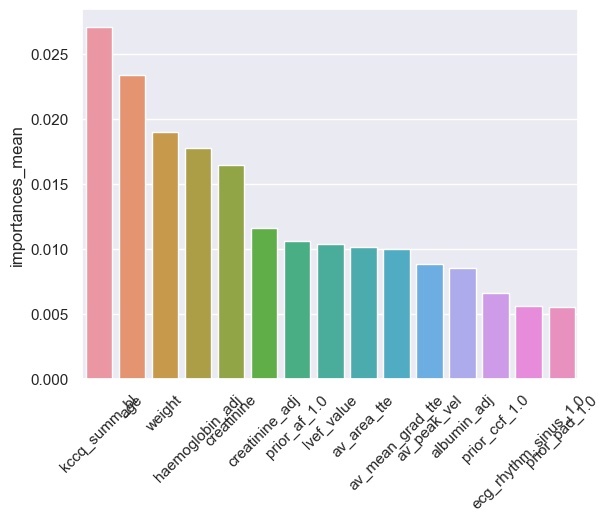

In [33]:
non_zero_rf_fi = rf_feature_importance.query('importances_mean > 5e-3')
ax = sns.barplot(non_zero_rf_fi, y = 'importances_mean',x=non_zero_rf_fi.index)
temp = plt.setp(ax.get_xticklabels(), rotation=45)

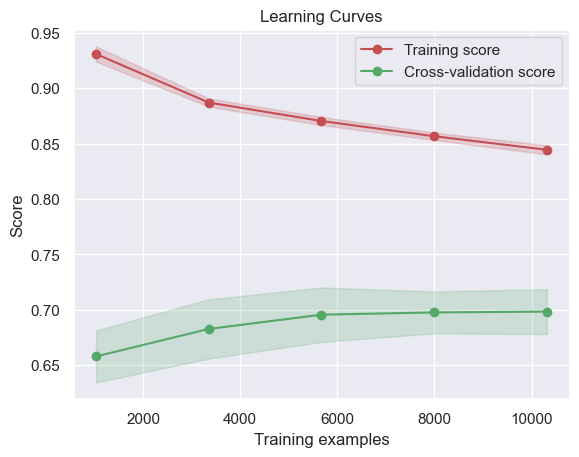

In [34]:
plot_learning_curve(gcv_iauc.best_estimator_, X_train, y_train, cv=n_folds)

In [ ]:
rf_feature_importance = pd.read_csv("results/rf_feature_importance_{}.csv".format(today_stf),index_col=0)

for n_features in [20,15,10,5]:
    gcv_iauc = GridSearchCV(
    rsf_pipeline,
    param_grid=cv_param_grid,
    cv=cv,
    verbose=10,
    n_jobs=4,
    return_train_score=True
).fit(X_train[rf_feature_importance.index[:n_features]], y_train)
    print(gcv_iauc.best_params_)
    print(gcv_iauc.best_score_)
    
    with open("model/rf_{}_nfeatures{}.pkl".format(today_stf,n_features), "wb") as f:
        dump(gcv_iauc, f, protocol=5)
        
    rf_results = evaluate_score(gcv_iauc.best_estimator_,X_test[gcv_iauc.best_estimator_.feature_names_in_],y_test,y_train,"rf",time_max=365,time_interval=7)
    results = pd.concat([results,rf_results],axis=0,ignore_index=True)
    results.to_csv(results_fn)
    print(results)  
    
    #plot_learning_curve(rsf_pipeline, X_train[non_zero_rf_fi.index[:n_features]], y_train, cv=n_folds)
    #plt.savefig("figures/rf_learning_curve{}.png".format(n_features),bbox_inches="tight")

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'model__estimator__max_depth': 12, 'model__estimator__max_features': 'sqrt', 'model__estimator__min_samples_leaf': 80, 'model__estimator__min_samples_split': 200, 'model__estimator__n_estimators': 200}
0.6934840345450715
          model   test_ci  test_ipcw  test_auc  test_brier  n_features
0           cph  0.692135   0.669471  0.698576    0.037291          75
1           cph  0.635765   0.630295  0.635606    0.036934           5
2           cph  0.662431   0.652060  0.658872    0.037187          10
3           cph  0.690876   0.675977  0.692287    0.036998          15
4           cph  0.687534   0.676775  0.686732    0.036937          20
5     ridge_cph  0.688925   0.675802  0.687202    0.036771          75
6     ridge_cph  0.685187   0.676750  0.677265    0.036880          20
7     ridge_cph  0.682904   0.677161  0.675049    0.036841          15
8     ridge_cph  0.681411   0.671781  0.671709    0.037094          10
9     ridge_cph  0.666902   0.664046  0.657276    0.037176          

C:\Users\harri\anaconda3\envs\tavi_survival\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'model__estimator__max_depth': 5, 'model__estimator__max_features': 'sqrt', 'model__estimator__min_samples_leaf': 40, 'model__estimator__min_samples_split': 120, 'model__estimator__n_estimators': 50}
0.6932511409045086
          model   test_ci  test_ipcw  test_auc  test_brier  n_features
0           cph  0.692135   0.669471  0.698576    0.037291          75
1           cph  0.635765   0.630295  0.635606    0.036934           5
2           cph  0.662431   0.652060  0.658872    0.037187          10
3           cph  0.690876   0.675977  0.692287    0.036998          15
4           cph  0.687534   0.676775  0.686732    0.036937          20
5     ridge_cph  0.688925   0.675802  0.687202    0.036771          75
6     ridge_cph  0.685187   0.676750  0.677265    0.036880          20
7     ridge_cph  0.682904   0.677161  0.675049    0.036841          15
8     ridge_cph  0.681411   0.671781  0.671709    0.037094          10
9     ridge_cph  0.666902   0.664046  0.657276    0.037176           5